## Imports and data filtering

In [39]:
import pandas as pd

# Date of analysis, change to pd.Timestamp.now() to get vulnerable devices right now assuming no reboots happened since 14/06/2025
ANALYSIS_DATE = pd.to_datetime('2025-06-14') 

# Import data
filename = 'outputs/results/combined_enterprise_output.csv'

df = pd.read_csv(filename)

# Merge rows for Brocade
df['Vendor'] = df['Vendor'].replace(
    "Brocade Communication Systems, Inc. (formerly 'Foundry Networks, Inc.')",
    "Brocade Communications Systems, Inc."
)

# Filter vendors in case we need more filtering 
excluded_vendors_file = "config/excluded_vendors.txt"
with open(excluded_vendors_file, 'r', encoding='utf-8') as file:
    excluded_vendors = {line.strip() for line in file if line.strip()}

# Filter out rows with engine time before 1998
df['Reboot_Datetime'] = pd.to_datetime(df['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')
df = df[df['Reboot_Datetime'].dt.year >= 1998]

df['Scan_Datetime'] =  pd.to_datetime(df['Scan Date'], format='%m_%d_%H_%M_%S')
df['Scan_Datetime'] = df['Scan_Datetime'].apply(lambda dt: dt.replace(year=2025))

size_before = df.shape[0]
df = df[~df["Vendor"].isin(excluded_vendors)]
df = df[df["Vendor"] != 'unknown']
print("Dropped " + str(size_before - df.shape[0]) + " by vendor exclusion.\n" + str(df.shape[0]) + " entries left.")

Dropped 1503 by vendor exclusion.
5874 entries left.


### Popular Vendors:


Vendor Counts:
Vendor
Ambit Microsystems Corporation          1407
Thomson Inc.                            1008
Brocade Communications Systems, Inc.     987
Arista networks                          730
H3C                                      436
Fortinet, Inc.                           262
Nokia (formerly 'Alcatel-Lucent')        251
SonicWALL, Inc.                          154
Broadcom Limited                          70
Compaq                                    55
Name: count, dtype: int64


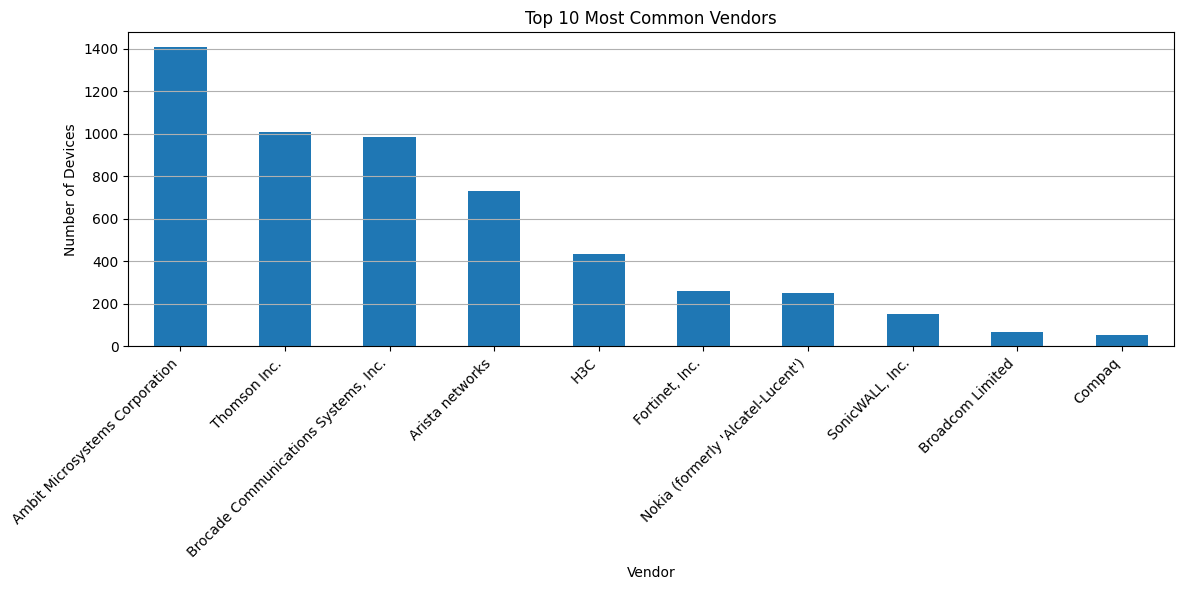

In [40]:
import matplotlib.pyplot as plt

# Get top 10 vendors by count
vendor_counts = df['Vendor'].value_counts().head(10)

# Create bar plot
plt.figure(figsize=(12, 6))
vendor_counts.plot(kind='bar')
plt.title('Top 10 Most Common Vendors')
plt.xlabel('Vendor')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()

# Print exact counts
print("\nVendor Counts:")
print(vendor_counts)

### Fetch CVEs for specific vendor:

In [42]:
from cve_matching import translate_vendor, fetch_CVEs_with_split

# Fetch CVEs for vendor
vendor = 'SonicWALL, Inc.' # NetScreen Technologies, Inc.'SonicWALL, Inc.' 'Fortinet, Inc.'
max_engine_time = df[df['Vendor'] == vendor]['Engine Time'].max()

translated_vendor = translate_vendor(vendor)
cves = fetch_CVEs_with_split(translated_vendor, max_engine_time, end_date=ANALYSIS_DATE)

print('Number of CVEs found:', len(cves))

Fetching CVEs for sonicwall, from 58170272.0s ago until 2025-06-14 00:00:00
This might take a while...
Number of CVEs found: 22


### Vulnerable IPs over time with CVE lines:

Oldest reboot: 2023-07-31 11:16:51


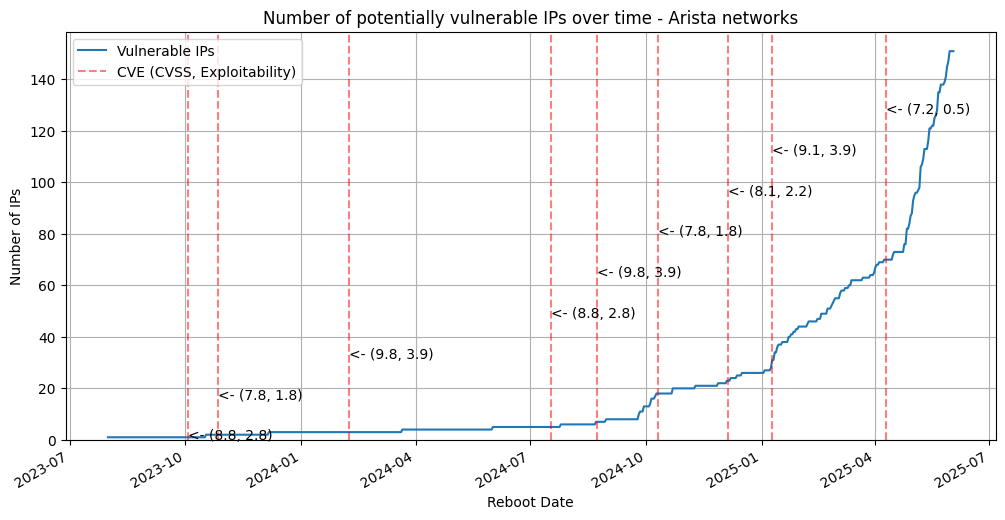

In [43]:
import matplotlib.pyplot as plt

# Filter dataframe for specified vendor
df_vendor = df[df['Vendor'] == vendor]

# Create time series of vulnerability counts
print(f'Oldest reboot: {df_vendor['Reboot_Datetime'].min()}')
time_range = pd.date_range(start=df_vendor['Reboot_Datetime'].min(), end=df_vendor['Reboot_Datetime'].max(), freq='D')
vulnerable_counts = []

for time_point in time_range:
    # Count IPs with reboot time older than this date -> meaning IP is potentially vulnerable
    vulnerable_ips = df_vendor[df_vendor['Reboot_Datetime'] <= time_point]['IP'].nunique()
    vulnerable_counts.append(vulnerable_ips)

# Create and plot the time series
vulnerability_ts = pd.Series(vulnerable_counts, index=time_range)
vulnerability_ts.plot(figsize=(12, 6))
plt.title(f'Number of potentially vulnerable IPs over time - Arista networks')
plt.xlabel('Reboot Date')
plt.ylabel('Number of IPs')
plt.grid(True)
plt.ylim(bottom=0)  # Force y-axis to start at 0

start_date = df_vendor['Reboot_Datetime'].min()

for _, cve in cves.iterrows():
    cve_id = cve['CVE_ID']
    published_str = cve['Published']
    cve_date = pd.to_datetime(published_str).normalize()

# Create a dictionary to store highest scoring CVE per date
cve_highest_scores = {}
CVSS_THRESHOLD = 7
EXPLOITABILITY_THRESHOLD = 0

for _, cve in cves.iterrows():
    cve_date = pd.to_datetime(cve['Published']).normalize()
    if cve['CVSS_Score'] > CVSS_THRESHOLD and cve['Exploitablity_Score'] > EXPLOITABILITY_THRESHOLD:
        if cve_date >= start_date and cve_date <= ANALYSIS_DATE:
            # Score for storing the "most serious" vulnerability for each day
            current_score = cve['CVSS_Score'] + cve['Exploitablity_Score']
            if cve_date not in cve_highest_scores or current_score > cve_highest_scores[cve_date]['score']:
                cve_highest_scores[cve_date] = {
                    'score': current_score,
                    'cvss': cve['CVSS_Score'],
                    'exploitability': cve['Exploitablity_Score']
                }

# Plot the highest scoring CVE per date
i = 0
for cve_date, scores in cve_highest_scores.items():
    plt.axvline(x=cve_date, color='r', linestyle='--', alpha=0.5)
    text_height = plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * (0.1 * (i % 9))
    plt.text(cve_date, text_height, f'<- ({scores["cvss"]:.1f}, {scores["exploitability"]:.1f})', 
             horizontalalignment='left', alpha=1)
    i += 1
plt.legend(['Vulnerable IPs', 'CVE (CVSS, Exploitability)'])



### CVE Statistics

In [44]:
# For each device, count CVEs published after its reboot date
cve_dates = pd.to_datetime(cves['Published']).dt.normalize()
device_cve_counts = []
for _, row in df_vendor.iterrows():
    reboot_date = row['Reboot_Datetime']
    # Count CVEs published after reboot date
    num_cves = (cve_dates > reboot_date).sum()
    device_cve_counts.append(num_cves)


average_cves_per_device = sum(device_cve_counts) / len(device_cve_counts) if device_cve_counts else 0
print(f"Average number of CVEs affecting each device: {average_cves_per_device:.2f}")

# Calculate and print the average CVSS score for all CVEs
average_cvss_score = cves['CVSS_Score'].mean()
print(f"Average CVSS score for all CVEs: {average_cvss_score:.2f}")

Average number of CVEs affecting each device: 3.20
Average CVSS score for all CVEs: 7.38


### Bulk fetch of vendor CVEs (takes a long time)

Fetches CVEs for all vendors in the list below and saves them to: outputs/results/all_vendors_cves.csv

The file config/all_vendors_cves.csv is the list gathered during our data analysis process.


In [ ]:
vendors = ["Arista networks", "Fortinet, Inc.", "SonicWALL, Inc.", "WatchGuard Technologies Inc.", "Aruba, a Hewlett Packard Enterprise company"]
vendor_cves = {}

df_important_vendors = df[df['Vendor'].isin(vendors)]

for v in vendors:
    max_engine_time = df_important_vendors[df_important_vendors["Vendor"] == v]["Engine Time"].max()
    translated_vendor = translate_vendor(v)
    cves = fetch_CVEs_with_split(translated_vendor, max_engine_time, end_date=ANALYSIS_DATE)
    if pd.isna(max_engine_time):
        vendor_cves[v] = None
        continue

    vendor_cves[v] = cves

for v, vendor_cves_df in vendor_cves.items():
    print(f"\nVendor: {v}")
    if vendor_cves_df is not None:
        print(f"Number of CVEs: {len(vendor_cves_df)}")
    else:
        print("No data available.")

# Save cve dataframe
combined_cves = []
for v, vendor_cves_df in vendor_cves.items():
    if vendor_cves_df is not None and not vendor_cves_df.empty:
        df_with_vendor = vendor_cves_df.copy()
        df_with_vendor['Vendor'] = v
        combined_cves.append(df_with_vendor)
if combined_cves:
    all_cves_df = pd.concat(combined_cves, ignore_index=True)
else:
    all_cves_df = pd.DataFrame()
print(all_cves_df.head())
all_cves_df.to_csv('outputs/results/all_vendors_cves.csv', index=False)

/tmp/ipykernel_699070/3481903171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interest['Reboot_Datetime'] = pd.to_datetime(df['Reboot Date'], format='%m_%d_%Y_%H_%M_%S')


193605560.0
2025-06-03 20:10:38
fetch
fetch
fetch
fetch


KeyboardInterrupt: 

### Reads CVE file for 'interesting' vendors and maps all their IPs to their corresponding AS

In [45]:
# Parse the CSV file into a DataFrame
all_cves_df = pd.read_csv("config/all_vendors_cves.csv")
zmap_df = pd.read_csv("config/ip_to_as_06_10.csv", dtype=str)

# Merge df and zmap_df to get ASN info for each IP
df_with_asn = df.merge(zmap_df[['IP', 'asn_num']], on='IP', how='left')

### Show average amount of CVEs per AS

In [46]:
ip_cve_counts = []

# Count CVEs per IP
for idx, row in df_with_asn.iterrows():
    ip = row['IP']
    vendor = row['Vendor']
    reboot_date = row['Reboot_Datetime']
    cves_vendor = all_cves_df[all_cves_df['Vendor'] == vendor]

    # Parse CVE published dates
    cve_dates = pd.to_datetime(cves_vendor['Published'], errors='coerce')

    # Count CVEs published after reboot date
    num_cves = (cve_dates > reboot_date).sum()
    ip_cve_counts.append(num_cves)

df_with_asn['cve_count'] = ip_cve_counts

# Compute average number of CVEs per AS
asn_cve_avg = df_with_asn.groupby('asn_num')['cve_count'].mean().sort_values(ascending=False)

## Per Vendor analysis

### Plot number of vulnerable IPs per vendor

Vulnerable IPs per vendor:
Arista networks: [730, 700, 651]
Fortinet, Inc.: [237, 147, 126]
SonicWALL, Inc.: [70, 23, 18]
WatchGuard Technologies Inc.: [2, 1, 0]
Thomson Inc.: [0, 0, 0]
Aruba, a Hewlett Packard Enterprise company: [12, 12, 7]

Total IPs per vendor:
Arista networks: 730
Fortinet, Inc.: 262
SonicWALL, Inc.: 154
WatchGuard Technologies Inc.: 18
Thomson Inc.: 1008
Aruba: 37


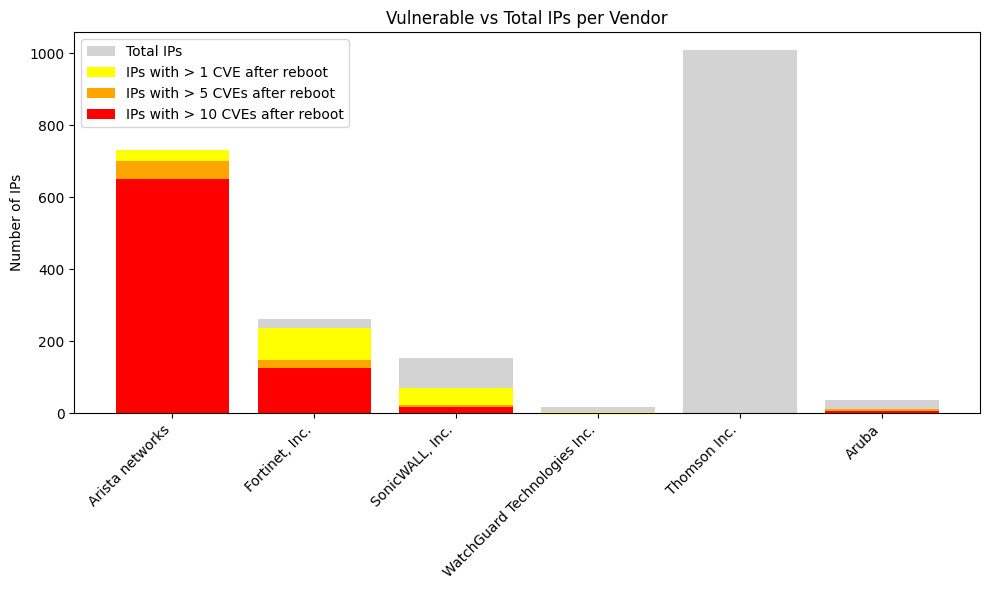

In [52]:


# Count the number of vulnerable IPs per vendor in the 'vendors' list
vendors_list = ["Arista networks", "Fortinet, Inc.", "SonicWALL, Inc.", "WatchGuard Technologies Inc.", "Thomson Inc.", "Aruba, a Hewlett Packard Enterprise company"]

# Define "vulnerable" as devices with a reboot date before the given date
vulnerable_counts = {}
for v in vendors_list:
    df_vendor = df[df['Vendor'] == v]
    counts = [0,0,0]
    for ip, row in df_vendor.iterrows():
        reboot_date = row['Reboot_Datetime']
        # Check if there is at least one CVE published after the reboot date for this vendor
        cves_vendor = all_cves_df[all_cves_df['Vendor'] == v]
        if cves_vendor is not None and not cves_vendor.empty:
            cve_dates = pd.to_datetime(cves_vendor[cves_vendor['CVSS_Score'] > 4]['Published'], errors='coerce')
            num_cves = (cve_dates > reboot_date).sum()
            if num_cves > 1:
                counts[0] += 1
            if num_cves > 5:
                counts[1] += 1
            if num_cves > 10:
                counts[2] += 1

    vulnerable_counts[v] = counts

print("Vulnerable IPs per vendor:")
for v, counts in vulnerable_counts.items():
    print(f"{v}: {counts}")

print("\nTotal IPs per vendor:")
for v in vendors_list:
    num_ips = df[df['Vendor'] == v]['IP'].nunique()
    if v == "Aruba, a Hewlett Packard Enterprise company":
        print(f"{"Aruba"}: {num_ips}")
    else:
        print(f"{v}: {num_ips}")

# Prepare data for plotting
vendors_plot = list(vulnerable_counts.keys())
vulnerable_0 = [vulnerable_counts[v][0] for v in vendors_plot]
vulnerable_1 = [vulnerable_counts[v][1] for v in vendors_plot]
vulnerable_2 = [vulnerable_counts[v][2] for v in vendors_plot]
total = [df[df['Vendor'] == v]['IP'].nunique() for v in vendors_plot]

x = range(len(vendors_plot))
plt.figure(figsize=(10, 6))
plt.bar(x, total, label='Total IPs', color='lightgray')
plt.bar(x, vulnerable_0, label='Vulnerable IPs', color='yellow')
plt.bar(x, vulnerable_1, label='Vulnerable IPs', color='orange')
plt.bar(x, vulnerable_2, label='Vulnerable IPs', color='red')
vendors_plot[-1] = "Aruba"
plt.xticks(x, vendors_plot, rotation=45, ha='right')
plt.ylabel('Number of IPs')
plt.title('Vulnerable vs Total IPs per Vendor')
plt.legend([
    'Total IPs',
    'IPs with > 1 CVE after reboot',
    'IPs with > 5 CVEs after reboot',
    'IPs with > 10 CVEs after reboot'
])
plt.tight_layout()
plt.show()

In [53]:
vulnerable_counts = {}
for v in vendors_list:
    df_vendor = df[df['Vendor'] == v]
    cve_sum = 0
    for ip, row in df_vendor.iterrows():
        reboot_date = row['Reboot_Datetime']
        # Check if there is at least one CVE published after the reboot date for this vendor
        vendor_cves_df = all_cves_df[all_cves_df['Vendor'] == v]
        if vendor_cves_df is not None and not vendor_cves_df.empty:
            cve_dates = pd.to_datetime(vendor_cves_df[vendor_cves_df['CVSS_Score'] > 0]['Published'], errors='coerce')
            num_cves = (cve_dates > reboot_date).sum()
            cve_sum += num_cves
            

    vulnerable_counts[v] = cve_sum / df_vendor.shape[0]

print("Vulnerable IPs per vendor:")
for v, counts in vulnerable_counts.items():
    print(f"{v}: {counts}")


Vulnerable IPs per vendor:
Arista networks: 28.904109589041095
Fortinet, Inc.: 28.068702290076335
SonicWALL, Inc.: 3.207792207792208
WatchGuard Technologies Inc.: 0.6111111111111112
Thomson Inc.: 0.0
Aruba, a Hewlett Packard Enterprise company: 25.35135135135135


### Average CVEs per vendor

Arista networks: CVEs/IP = 28.90, Exploitability/IP = 83.90
Fortinet, Inc.: CVEs/IP = 28.07, Exploitability/IP = 57.47
SonicWALL, Inc.: CVEs/IP = 3.21, Exploitability/IP = 5.15
WatchGuard Technologies Inc.: CVEs/IP = 0.61, Exploitability/IP = 1.64
Thomson Inc.: CVEs/IP = 0.00, Exploitability/IP = 0.00
Aruba, a Hewlett Packard Enterprise company: CVEs/IP = 25.35, Exploitability/IP = 51.91


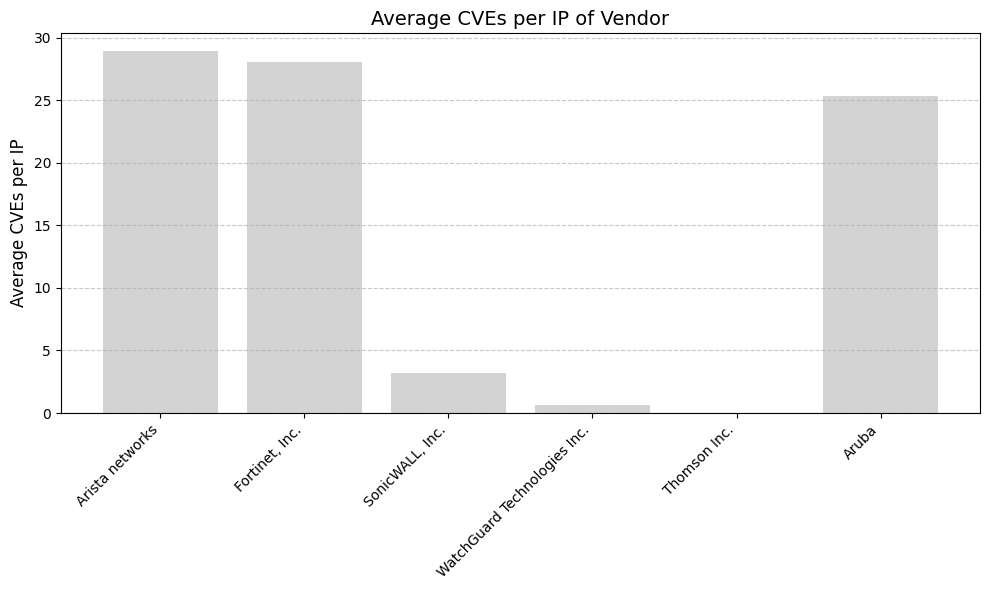

Arista networks
1486    2.8
1487    2.8
1488    3.9
1489    3.9
1490    3.9
       ... 
1544    3.9
1545    3.9
1546    3.9
1547    3.9
1548    1.2
Name: Exploitablity_Score, Length: 63, dtype: float64
Fortinet, Inc.
330    2.8
331    2.8
332    3.9
333    1.8
334    1.8
      ... 
678    3.9
679    2.2
680    0.8
681    3.9
682    2.2
Name: Exploitablity_Score, Length: 353, dtype: float64
SonicWALL, Inc.
683    3.9
684    3.9
685    3.9
686    2.8
687    2.8
      ... 
760    3.9
761    0.5
762    0.5
763    0.5
764    1.8
Name: Exploitablity_Score, Length: 82, dtype: float64
WatchGuard Technologies Inc.
1640    2.8
1641    3.9
1642    3.9
1643    2.8
1644    2.8
1645    2.8
1646    2.8
1647    2.8
1648    2.8
1649    2.8
1650    3.9
1651    3.9
1652    3.9
1653    3.9
1654    1.8
1655    2.3
1656    1.8
1657    0.8
1658    1.8
1659    1.8
1660    1.8
1661    1.8
1662    1.2
1663    3.9
1664    3.9
1665    3.9
1666    1.8
1667    2.8
1668    NaN
1669    NaN
1670    NaN
1671    NaN
167

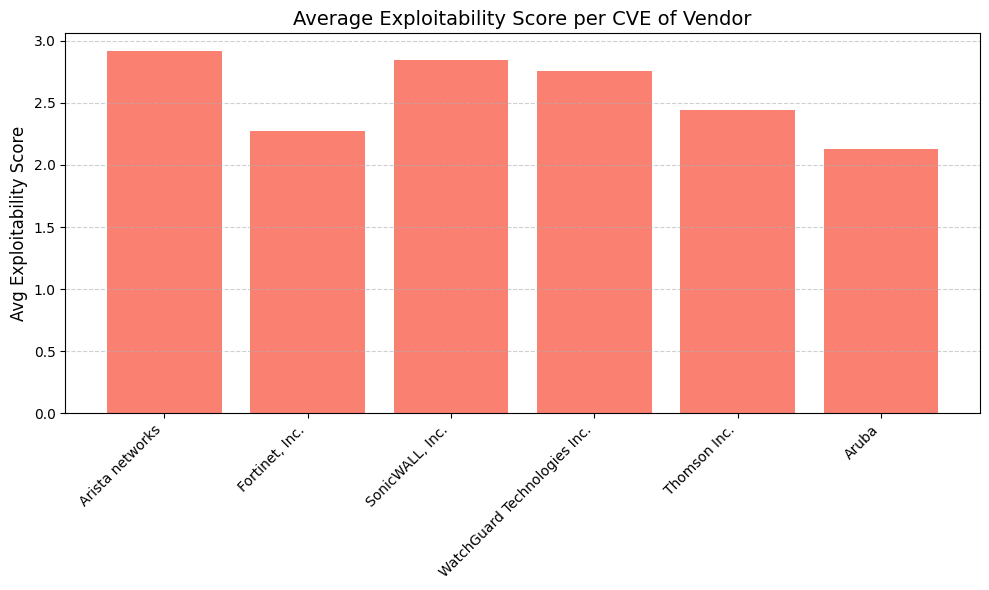

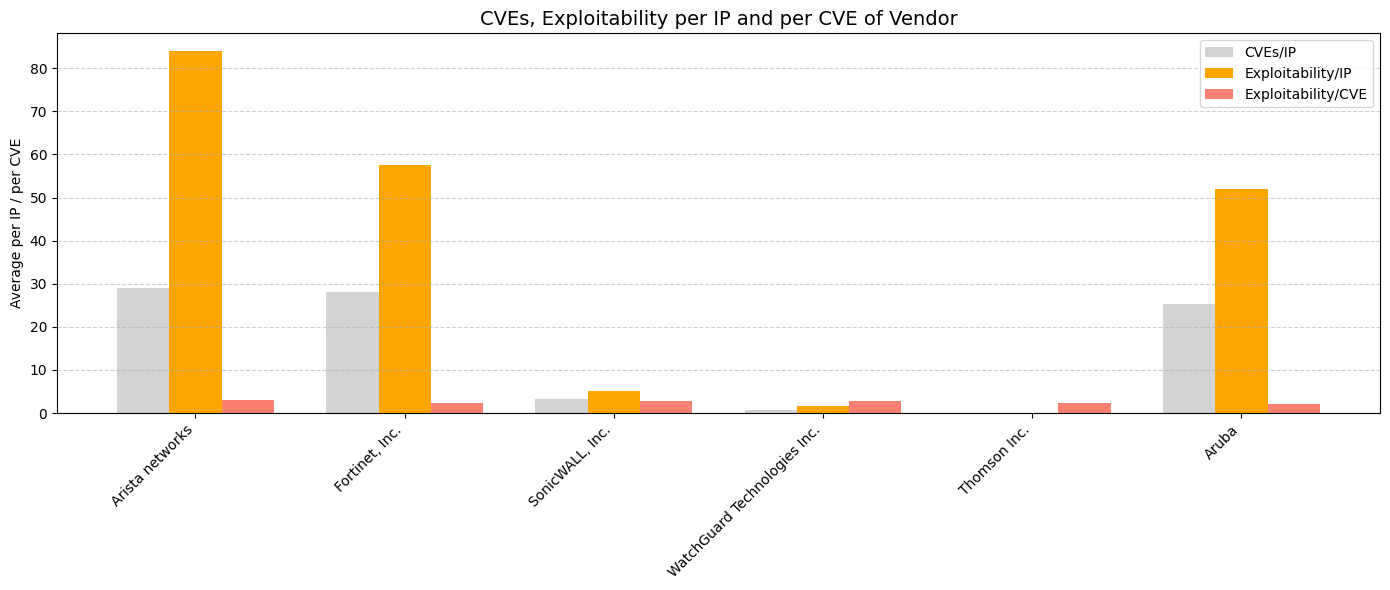

In [ ]:
import numpy as np

vulnerable_counts1 = {}
exploitability_totals1 = {}
# Count CVEs per IP

for v in vendors_list:
    df_vendor1 = df[df['Vendor'] == v].dropna(subset=['Reboot_Datetime'])
    cve_sum1 = 0
    exploit_sum1 = 0

    for _, row in df_vendor1.iterrows():
        reboot_date1 = row['Reboot_Datetime']
        cves_df1 = all_cves_df[all_cves_df['Vendor'] == v]

        if cves_df1 is not None and not cves_df1.empty:
            filtered = cves_df1[(cves_df1['CVSS_Score'] > 0)].copy()
            filtered['Published'] = pd.to_datetime(filtered['Published'], errors='coerce')
            after_reboot = filtered[filtered['Published'] > reboot_date1]

            num_cves1 = after_reboot.shape[0]
            exploit_score1 = after_reboot['Exploitablity_Score'].sum()

            cve_sum1 += num_cves1
            exploit_sum1 += exploit_score1

    avg_cves1 = cve_sum1 / df_vendor1.shape[0] if not df_vendor1.empty else 0
    avg_exploit1 = exploit_sum1 / df_vendor1.shape[0] if not df_vendor1.empty else 0

    vulnerable_counts1[v] = avg_cves1
    exploitability_totals1[v] = avg_exploit1

for v, avg in vulnerable_counts1.items():
     print(f"{v}: CVEs/IP = {vulnerable_counts1[v]:.2f}, Exploitability/IP = {exploitability_totals1[v]:.2f}")

vendors1 = list(vulnerable_counts1.keys())
vendors1[-1] = "Aruba"
avg_cves1 = list(vulnerable_counts1.values())

plt.figure(figsize=(10, 6))
plt.bar(vendors1, avg_cves1, color='lightgray')
plt.title('Average CVEs per IP of Vendor', fontsize=14)
plt.ylabel('Average CVEs per IP', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

avg_exploit_score_per_cve = {}

for v in vulnerable_counts1.keys():
    vendor_cves_df = all_cves_df[all_cves_df['Vendor'] == v]
    if vendor_cves_df is not None and not vendor_cves_df.empty:
        avg_exploit_score_per_cve[v] = vendor_cves_df['Exploitablity_Score'].mean()
    else:
        avg_exploit_score_per_cve[v] = 0.0

vendor_labels = list(avg_exploit_score_per_cve.keys())
exploit_scores = list(avg_exploit_score_per_cve.values())
vendor_labels[-1] = "Aruba"

plt.figure(figsize=(10, 6))
plt.bar(vendor_labels, exploit_scores, color='salmon')
plt.title('Average Exploitability Score per CVE of Vendor', fontsize=14)
plt.ylabel('Avg Exploitability Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

vendors1 = list(vulnerable_counts1.keys())
x = np.arange(len(vendors1))
width = 0.25

avg_cves1 = [vulnerable_counts1[v] for v in vendors1]
avg_exploit1 = [exploitability_totals1[v] for v in vendors1]
avg_exploit_per_cve = [avg_exploit_score_per_cve.get(v, 0.0) for v in vendors1]

vendors1_display = vendors1.copy()
vendors1_display[-1] = "Aruba"

plt.figure(figsize=(14, 6))
plt.bar(x - width,     avg_cves1,           width, label='CVEs/IP', color='lightgray')
plt.bar(x,             avg_exploit1,        width, label='Exploitability/IP', color='orange')
plt.bar(x + width,     avg_exploit_per_cve, width, label='Exploitability/CVE', color='salmon')

plt.xticks(x, vendors1_display, rotation=45, ha='right')
plt.ylabel('Average per IP / per CVE')
plt.title('CVEs, Exploitability per IP and per CVE of Vendor', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()